In [1]:
# !/usr/local/bin/pip3.9 install seaborn
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [169]:
def calculate_n(u, t, k):
    ns = ( ((t + (k - 1)*u)/k) * (1 - (t + (k - 1)*u)/k) ) / (1/k)**2
    return ns

u_vals = [i/10 for i in range(1,10,2)]
t_vals = [i/10 for i in range(1,10,2)]
k_vals = [i/100 for i in range(100,500,1)]
results = []
for u,t in product(u_vals, t_vals):
    for k in k_vals:
        n_vals = {
            'u': u,
            't': t,
            'k': k,
            'n_tag': calculate_n(u, t, k),
            'n': calculate_n(u, t, k=1)
        }
        results.append(n_vals)
            
df = pd.DataFrame(results)
df['n_ratio'] = df['n_tag'] / df['n']
df['t_u'] = df['t'].astype(str)+'_'+df['u'].astype(str)
df

,u,t,k,n_tag,n,n_ratio,t_u
0,0.1,0.1,1.00,0.090000,0.09,1.0000,0.1_0.1
1,0.1,0.1,1.01,0.091809,0.09,1.0201,0.1_0.1
2,0.1,0.1,1.02,0.093636,0.09,1.0404,0.1_0.1
3,0.1,0.1,1.03,0.095481,0.09,1.0609,0.1_0.1
4,0.1,0.1,1.04,0.097344,0.09,1.0816,0.1_0.1
...,...,...,...,...,...,...,...
9995,0.9,0.9,4.95,2.205225,0.09,24.5025,0.9_0.9
9996,0.9,0.9,4.96,2.214144,0.09,24.6016,0.9_0.9
9997,0.9,0.9,4.97,2.223081,0.09,24.7009,0.9_0.9
9998,0.9,0.9,4.98,2.232036,0.09,24.8004,0.9_0.9


Text(0.5, 0.98, 'Overtracking by treated/untreated')

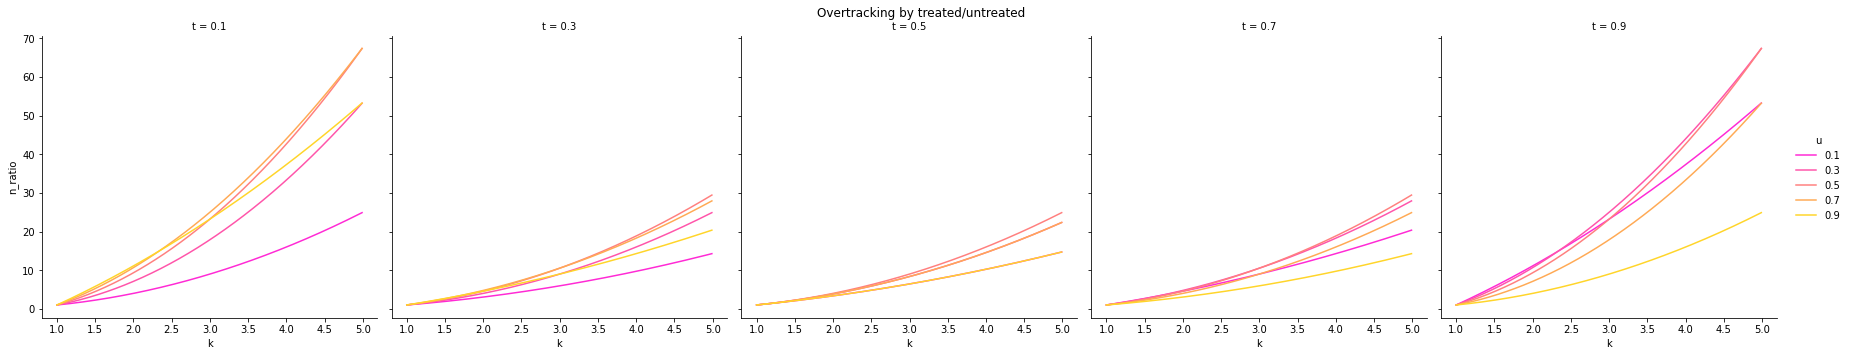

In [168]:
def const_line(*args, **kwargs):
    x = np.arange(1, 5, .01)
    y = x
    plt.plot(y, x)


g = sns.FacetGrid(data = df.sort_values(by='k'),
                  height=5, aspect=1, col='t', 
                  col_wrap = 5,
                  hue='u', palette='spring', hue_order=df['u'].sort_values().unique())
g.map(sns.lineplot, 'k', 'n_ratio')
g.add_legend()
plt.subplots_adjust(top=0.9) 
# g.map(const_line)
g.fig.suptitle('Overtracking by treated/untreated')